In [1]:
import sys

PWD = '..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.plot_utils import plot_sample
from src.cfd import CFD

In [2]:
dataset = np.load(f'../data/dataset.npz', allow_pickle=True)

In [3]:
all_X, all_y = dataset['X'], dataset['y']

all_X.shape, all_y.shape

((19597, 64), (19597,))

# Preprocess

In [4]:
n_baseline = 20

In [5]:
all_X -= np.mean(all_X[:, :n_baseline], axis=1)[:, None]

all_X /= all_X.max(axis=1)[:, None]

In [6]:
import random

In [7]:
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)

# Utils

In [8]:
def plot_history(history, title, ymax=None):
    plt.figure(figsize=(10, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    plt.plot(X, history['loss'], label='train')
    plt.plot(X, history['val_loss'], label='test')
    
    if ymax is not None:
        plt.ylim(0, ymax)

    plt.title(f"val loss ({history[f'val_loss'][-1]:0.4f})")
    plt.grid()
    plt.legend()
        
    plt.suptitle(title)
    plt.show()
    
def plot_samples(X, y, y_pred, indices=[0, 100, 200, 500, 1000, 1200, 1500, 2137]):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(X[idx])
        plt.axvline(y[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')

# CFD

In [9]:
cfd = CFD(fraction=0.1)

y_pred = []
for x in X_test:
    y_pred.append(cfd.predict(x))
    
y_pred = np.array(y_pred)
y_pred.shape

(3920,)

In [10]:
mean_squared_error(y_test, y_pred)

0.7465342188922153

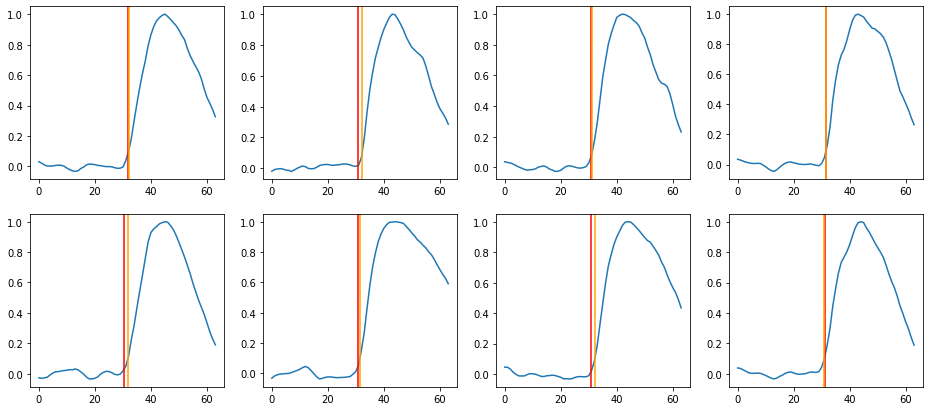

In [11]:
plt.figure(figsize=(16, 7))
plot_samples(X_test, y_test, y_pred)

# Model 1

In [12]:
model = keras.Sequential([
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.1))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20))

history = model.fit(X_train, y_train, epochs=1000, verbose=1, batch_size=1024, validation_data=(X_test, y_test), callbacks=model_callbacks)

Epoch 1/1000
16/16 [==============================] - 1s 12ms/step - loss: 340.5235 - val_loss: 4.7200 - lr: 0.1000
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 33.9194 - val_loss: 21.2674 - lr: 0.1000
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 7.8660 - val_loss: 7.6799 - lr: 0.1000
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 5.1631 - val_loss: 3.2850 - lr: 0.1000
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 3.4734 - val_loss: 2.9251 - lr: 0.1000
Epoch 6/1000
16/16 [==============================] - 0s 4ms/step - loss: 3.0707 - val_loss: 2.7997 - lr: 0.1000
Epoch 7/1000
16/16 [==============================] - 0s 4ms/step - loss: 2.8825 - val_loss: 2.6635 - lr: 0.1000
Epoch 8/1000
16/16 [==============================] - 0s 5ms/step - loss: 2.7354 - val_loss: 2.5336 - lr: 0.1000
Epoch 9/1000
16/16 [==============================] - 0s 7ms/step - loss: 2.5996 - val_loss

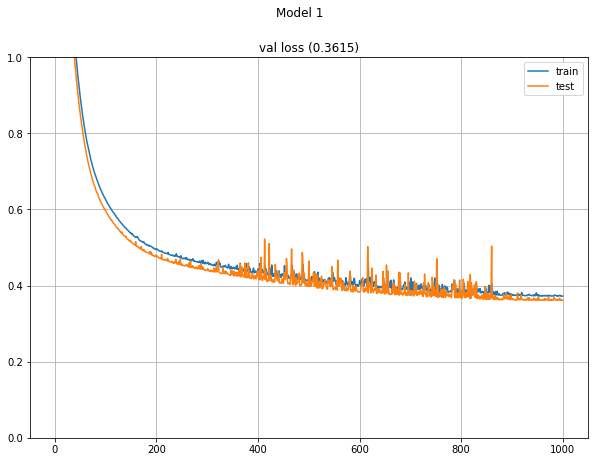

In [13]:
plot_history(history.history, "Model 1", ymax=1)

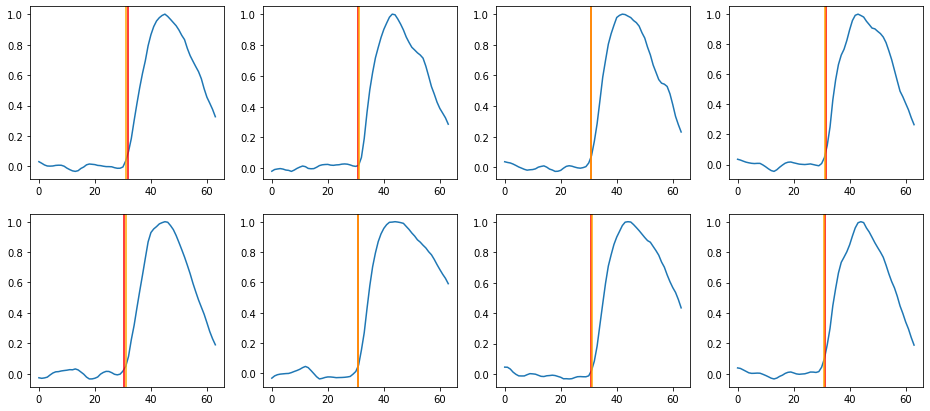

In [14]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)
plot_samples(X_test, y_test, y_pred)

# Model 3

In [15]:
model = keras.Sequential([
    layers.Input(64),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Flatten(),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.1))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20))

history = model.fit(X_train, y_train, epochs=600, verbose=1, batch_size=1024, validation_data=(X_test, y_test), callbacks=model_callbacks)

Epoch 1/600
16/16 [==============================] - 2s 38ms/step - loss: 341.0030 - val_loss: 37.8236 - lr: 0.1000
Epoch 2/600
16/16 [==============================] - 0s 10ms/step - loss: 24.7578 - val_loss: 2.1226 - lr: 0.1000
Epoch 3/600
16/16 [==============================] - 0s 10ms/step - loss: 5.3456 - val_loss: 1.0549 - lr: 0.1000
Epoch 4/600
16/16 [==============================] - 0s 10ms/step - loss: 1.5184 - val_loss: 0.7424 - lr: 0.1000
Epoch 5/600
16/16 [==============================] - 0s 10ms/step - loss: 0.7393 - val_loss: 0.5621 - lr: 0.1000
Epoch 6/600
16/16 [==============================] - 0s 9ms/step - loss: 0.4970 - val_loss: 0.4179 - lr: 0.1000
Epoch 7/600
16/16 [==============================] - 0s 10ms/step - loss: 0.4286 - val_loss: 0.4006 - lr: 0.1000
Epoch 8/600
16/16 [==============================] - 0s 10ms/step - loss: 0.4151 - val_loss: 0.4096 - lr: 0.1000
Epoch 9/600
16/16 [==============================] - 0s 9ms/step - loss: 0.4096 - val_loss: 0

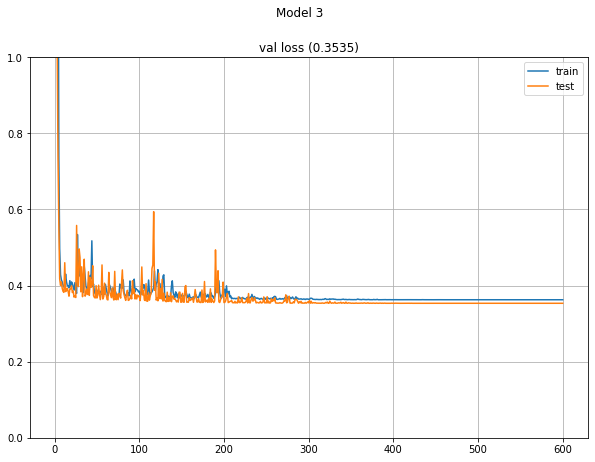

In [16]:
plot_history(history.history, "Model 3", ymax=1)

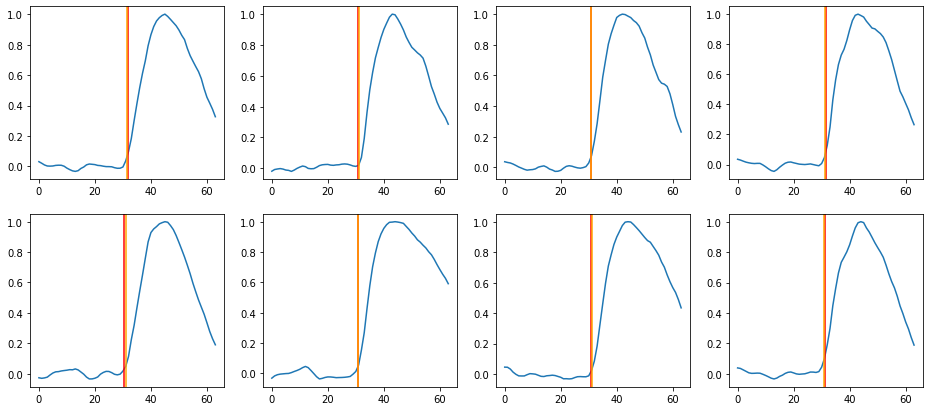

In [17]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)
plot_samples(X_test, y_test, y_pred)